In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

from IPython.display import clear_output

In [2]:
import fulu
import utils
from binned_split import binned_train_test_split
from copy import deepcopy

In [3]:
from joblib import Parallel, delayed

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Read data

In [5]:
data = pd.read_csv('../data/plasticc/good_objects_peak.csv')

data = data[data.detected_bool == 1]
data = data[data.true_target.isin([90])]

In [6]:
data.head()

,Unnamed: 0,object_id,mjd,passband,flux,flux_err,detected_bool,log_lam,class,true_peakmjd,true_target
23,1157,745,60125.4094,2,220.795212,1.492162,1,3.790512,1,60130,90
24,1158,745,60125.4171,1,192.244293,1.432564,1,3.675929,1,60130,90
25,1159,745,60125.4248,3,203.250702,1.862000,1,3.875155,1,60130,90
26,1160,745,60125.4357,4,183.633118,2.818825,1,3.938479,1,60130,90
27,1161,745,60125.4448,5,141.513290,11.663839,1,3.987288,1,60130,90


In [7]:
object_ids = np.unique(data.object_id)

In [8]:
passband2name = {0: 'u', 1: 'g', 2: 'r', 3: 'i', 4: 'z', 5: 'y'}
passband2lam  = {0: np.log10(3751.36), 1: np.log10(4741.64), 2: np.log10(6173.23), 
                 3: np.log10(7501.62), 4: np.log10(8679.19), 5: np.log10(9711.53)}

# Utils

In [9]:
def get_object(data, object_id):
    anobject = data[data.object_id == object_id]
    return anobject

In [10]:
def get_passband(anobject, passband):
    light_curve = anobject[anobject.passband == passband]
    return light_curve

In [11]:
def add_log_lam(anobject):
    passbands = anobject.passband.values
    log_lam = [passband2lam[i] for i in passbands]
    anobject['log_lam'] = log_lam
    return anobject

In [12]:
def is_good(anobject):
    
    true_target = anobject['true_target'].values[0]
    if true_target not in [90]:
        return 0
    
    peak_mjd = anobject['true_peakmjd'].values[0]
    if peak_mjd < anobject['mjd'].min() or peak_mjd > anobject['mjd'].max():
        return 0
    
    # remove all objects with negative flux values
    if anobject['flux'].values.min() < 0:
        return 0
    
    # keep only objects with at least 7 observations in at least 3 passbands
    count = 0
    for passband in range(6):
        if len(get_passband(anobject, passband)) < 7:
            count += 1
    if count > 3:
        return 0
        
    # keep only objects without large breaks in observations
    anobject = anobject.sort_values('mjd')
    mjd = anobject['mjd'].values
    if np.diff(mjd, 1).max() > 50:
        return 0
    
    return 1

In [13]:
def compile_obj(t, flux, flux_err, passband):
    obj = pd.DataFrame()
    obj['mjd']      = t
    obj['flux']     = flux
    obj['flux_err'] = flux_err
    obj['passband'] = passband
    return obj

# Visualization

In [14]:
def plot_light_curves(anobject, title=""):
    anobject = anobject.sort_values('mjd')
    plt.figure(figsize=(9, 4))
    for passband in range(6):
        light_curve = get_passband(anobject, passband)
        plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=0.5)
        plt.scatter(light_curve['mjd'].values, light_curve['flux'].values, label=passband2name[passband], linewidth=1)
    plt.xlabel('Modified Julian Date', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)

In [15]:
def plot_light_curves_with_sigma(t, flux, flux_err, passband, title=""):
    colors = ['C'+str(i) for i in range(len(np.unique(passband)))]
    plt.figure(figsize=(9, 4))
    for i, pb in enumerate(np.unique(passband)):
        plt.plot(t[passband == pb], flux[passband == pb], linewidth=2., color=colors[i])
        plt.fill_between(t[passband == pb], 
                         flux[passband == pb]+1*flux_err[passband == pb], 
                         flux[passband == pb]-1*flux_err[passband == pb], label=passband2name[pb], alpha=0.5, color=colors[i])
    plt.xlabel('Time', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)

195


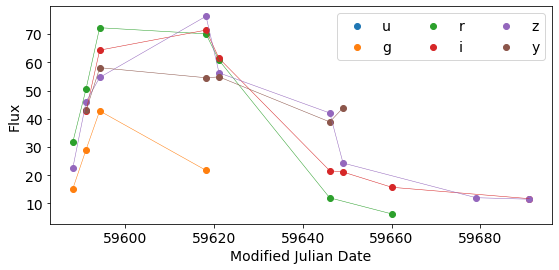

409


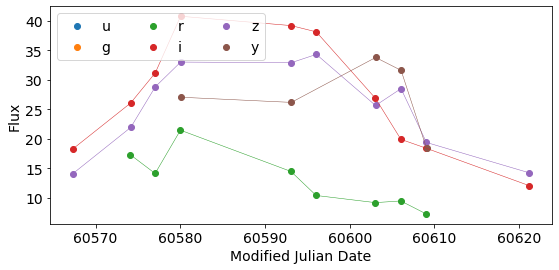

413


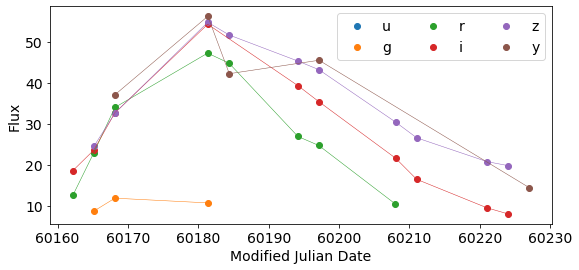

466


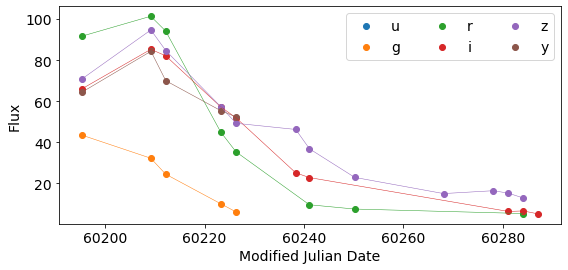

687


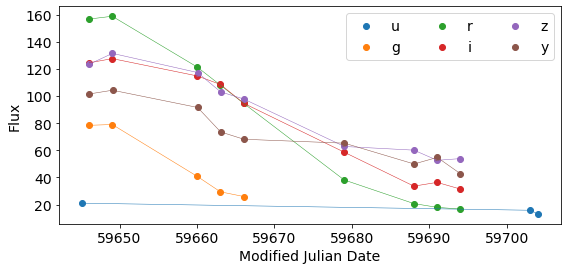

745


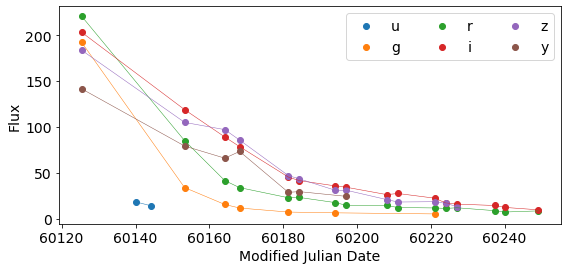

833


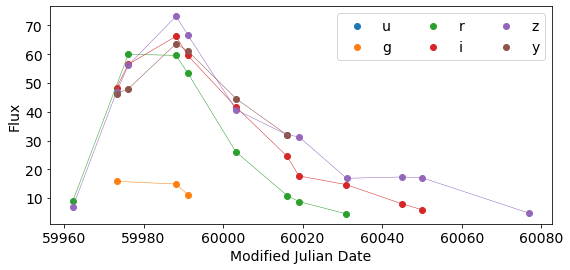

In [16]:
for i in object_ids[:20]:
    anobject = get_object(data, i)
    if not is_good(anobject):
        continue
    print(i)
    plot_light_curves(anobject)
    plt.show()

# One object test Test

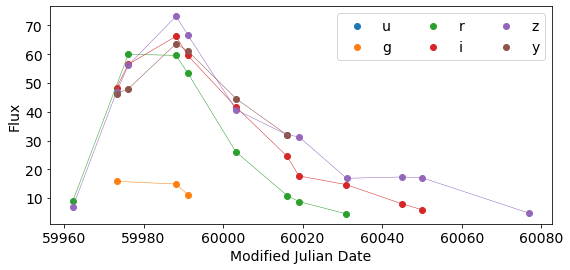

In [17]:
anobject = get_object(data, 833) # 34299, 329277
anobject = add_log_lam(anobject)

plot_light_curves(anobject)
# plt.savefig('light_curve_34299.pdf', format='pdf')

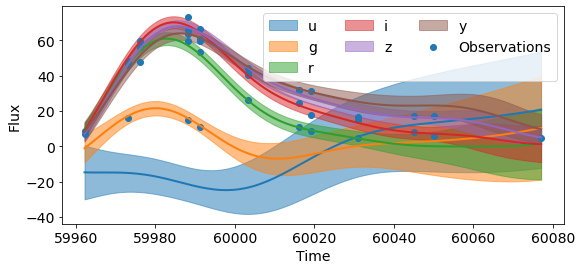

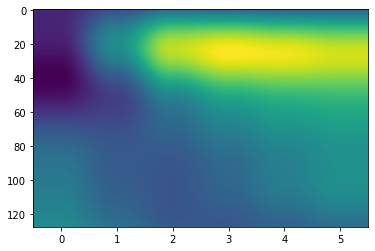

In [18]:
n_obs = 128

# train test split
t = anobject['mjd'].values
flux = anobject['flux'].values
flux_err = anobject['flux_err'].values
passband = anobject['passband'].values
true_peak = anobject['true_peakmjd'].values[0]

# approximation model
aug = fulu.GaussianProcessesAugmentation(passband2lam)
aug.fit(t, flux, flux_err, passband)

# augmentation
t_aug, flux_aug, flux_err_aug, passband_aug= aug.augmentation(t_min=t.min(), t_max=t.max(), n_obs=n_obs)

# convert values to 2D-array
anobject_aug = compile_obj(t_aug, flux_aug, flux_err_aug, passband_aug)
anobject_aug = anobject_aug.drop('flux_err', axis=1).set_index(['mjd', 'passband']).unstack(level=1)
data_array = anobject_aug.values.T
timestamps = np.array(anobject_aug.index)

# add target value for this curve
true_class = int(anobject['class'].to_numpy()[0])


# plotting
plot_light_curves_with_sigma(t_aug, flux_aug, flux_err_aug, passband_aug, title="")
plt.scatter(t, flux, label='Observations')
plt.legend(loc='best', ncol=3, fontsize=14)
plt.show()

plt.imshow(data_array.T, aspect='auto')
plt.show()

In [19]:
anobject_aug

flux                                                       
passband              0          1          2          3          4          5
mjd                                                                           
59962.194300 -14.711287  -1.081371   9.632491   8.612301   7.238991   8.209704
59963.098343 -14.769243   0.509921  12.753606  11.974578  10.313557  10.898686
59964.002387 -14.802565   2.137360  15.942275  15.429553  13.489516  13.686587
59964.906430 -14.817023   3.786290  19.176738  18.955238  16.747210  16.556397
59965.810473 -14.818525   5.441659  22.434455  22.528654  20.065949  19.490107
...                 ...        ...        ...        ...        ...        ...
60073.391627  19.471347   8.817413   0.653471   1.720700   6.621176  11.890129
60074.295670  19.777289   9.193126   0.826043   1.549911   6.177665  11.282906
60075.199713  20.088342   9.582632   1.025205   1.412275   5.768215  10.707813
60076.103757  20.404206   9.985989   1.252569   1.311140   5.397339  10.169939
60077.007800  20.724549  10.403175   1.509556   1.249570   5.069214   9.674020

[128 rows x 6 columns]

# Image preparation

In [20]:
N_obs = 128

In [21]:
def get_images(outputs, silent=False):
    images = []
    timestamps = []
    true_peaks = []
    for img in outputs:
        if img is not None:
            true_peaks.append(img[1])
            images.append(img[0])
            timestamps.append(img[2])
    images = np.array(images)
    true_peaks = np.array(true_peaks)
    timestamps = np.array(timestamps)
    return images, true_peaks, timestamps

In [22]:
def one_object_run(i):
    
    # get an object
    anobject = get_object(data, i)
    anobject = add_log_lam(anobject)
    
    # take only good curves
    if not is_good(anobject): 
        return None
    
    # train test split
    t = anobject['mjd'].values
    flux = anobject['flux'].values
    flux_err = anobject['flux_err'].values
    passband = anobject['passband'].values
    true_peak = anobject['true_peakmjd'].values[0]
    
    # approximation model
    if MODEL == "GP":
        aug = fulu.GaussianProcessesAugmentation(passband2lam)
    elif MODEL == "NN_sklearn":
        aug = fulu.MLPRegressionAugmentation(**params)
    elif MODEL == "NN_pytorch":
        aug = fulu.SingleLayerNetAugmentation(**params)
    elif MODEL == "BNN":
        aug = fulu.BayesianNetAugmentation(**params)
    elif MODEL == "NF":
        aug = fulu.NormalizingFlowAugmentation(**params)

    # fit the model
    aug.fit(t, flux, flux_err, passband)

    # augmentation
    t_aug, flux_aug, flux_err_aug, passband_aug= aug.augmentation(t_min=t.min(), t_max=t.max(), n_obs=N_obs)

    # convert values to 2D-array
    anobject_aug = compile_obj(t_aug, flux_aug, flux_err_aug, passband_aug)
    anobject_aug = anobject_aug.drop('flux_err', axis=1).set_index(['mjd', 'passband']).unstack(level=1)
    image = anobject_aug.values.T
    timestamps = np.array(anobject_aug.index)
    
    return (image, true_peak, timestamps)

# Direct method

In [23]:
def direct_peak_estimation(images, timestamps):
    peak_pred = []
    for i in range(len(images)):
        img = images[i]
        ts = timestamps[i]
        peak_pred.append(ts[img.sum(axis=0).argmax()])
    return np.array(peak_pred)

# Classifier preparation

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

device = 'cpu'

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn = nn.Sequential(
                                    nn.Conv1d(6, 8, 3, padding=1),
                                    nn.LayerNorm((8, 128)),
                                    nn.ReLU(),
                                    nn.MaxPool1d(2),
                                    nn.Conv1d(8, 16, 3, padding=1),
                                    nn.LayerNorm((16, 64)),
                                    nn.ReLU(),
                                    nn.MaxPool1d(2),
                                    nn.Conv1d(16, 32, 3, padding=1),
                                    nn.LayerNorm((32, 32)),
                                    nn.ReLU(),
                                    nn.MaxPool1d(2),
                                    nn.Flatten(),
                                    nn.Dropout(0.33),
                                    nn.Linear(16 * 32, 1)
                                )

    def forward(self, x):
        x = self.cnn(x)
        return x

In [25]:
Net()

Net(
  (cnn): Sequential(
    (0): Conv1d(6, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): LayerNorm((8, 128), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): LayerNorm((16, 64), eps=1e-05, elementwise_affine=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): LayerNorm((32, 32), eps=1e-05, elementwise_affine=True)
    (10): ReLU()
    (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten()
    (13): Dropout(p=0.33, inplace=False)
    (14): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [26]:
def peak_transfrom(true_peaks, timestamps):
    y = (true_peaks - timestamps[:, 0]) / (timestamps[:, -1] - timestamps[:, 0])
    y = np.log(y / (1 - y))
    return y

def peak_inverse_transform(y, timestamps):
    peak = 1 / (1 + np.exp(-np.array(y)))
    peak = peak * (timestamps[:, -1] - timestamps[:, 0]) + timestamps[:, 0]
    return peak

In [27]:
def light_curve_peak(images, true_peaks, timestamps):
    

    # train / test split data
    X_train, X_test, y_train, y_test, ts_train, ts_test = train_test_split(images, 
                                                                            true_peaks,
                                                                            timestamps,
                                                                            test_size=0.4,
                                                                            random_state=42)
    
    y_train = peak_transfrom(y_train, ts_train)
    y_test = peak_transfrom(y_test, ts_test)

    # normalize input data
    X_train_norm = np.array((X_train - X_train.mean()) / X_train.std(), dtype=np.float32)
    X_test_norm = np.array((X_test - X_train.mean()) / X_train.std(), dtype=np.float32)

    # convert train data to tensors
    X_train_tensor = torch.from_numpy(X_train_norm)
    y_train_tensor = torch.from_numpy(np.array(y_train, dtype=np.float32))

    batch = 8
    # create train data loader
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch,
                                              shuffle=True, drop_last=False)
    

    # convert test data to tensors
    X_test_tensor = torch.from_numpy(X_test_norm)
    y_test_tensor = torch.from_numpy(np.array(y_test, dtype=np.float32))


    # initialize binary classifier
    net = Net()
    optimizer = torch.optim.Adam(net.parameters(), 0.0003)
    # sched = torch.optim.lr_scheduler.StepLR(optimizer, 100)
    criterion = nn.MSELoss()

    epochs = np.arange(500)

    best_loss = float('inf')
    best_state = None
    loss_history = []
    test_history = []

    for epoch in tqdm(epochs):  # loop over the dataset multiple times
        epoch_loss = 0.0
        n_batches = 0
        net = net.train()
        for info in trainloader:
            # get the inputs; info is a list of [inputs, labels]
            inputs, labels_batch = info
            outputs = net(inputs).view(-1)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_loss += loss.item()
            n_batches += 1
        # sched.step()
        # print mean loss for the epoch
        epoch_loss = epoch_loss / n_batches
        loss_history.append(epoch_loss)

        net = net.eval()
        y_test_tensor_pred = net(X_test_tensor).view(-1)
        test_loss = criterion(y_test_tensor_pred, y_test_tensor).item()
        test_history.append(test_loss)
        
        if test_loss <= best_loss:
            best_loss = test_loss
            best_state = deepcopy(net.state_dict())

        if (epoch + 1) % 10 == 0:
            clear_output(wait=True)
            fig = plt.figure(figsize=(12, 6))
            plt.title("Model Loss Depending on Epoch Number", fontsize=20)
            plt.plot(loss_history, label="train loss")
            plt.plot(test_history, label="test loss")
            plt.legend(loc="best", shadow=0.1, fontsize=16)
            plt.xlabel("Epoch Number", fontsize=16)
            plt.ylabel("MSE Loss", fontsize=16)
            plt.grid(True)
            plt.show()

    net.load_state_dict(best_state)
    y_test_pred = net(X_test_tensor).view(-1).detach().numpy()
    y_test_pred = peak_inverse_transform(y_test_pred, ts_test)
    y_test = peak_inverse_transform(y_test, ts_test)

    return X_test, y_test, y_test_pred

In [28]:
from sklearn.utils import resample

def gen_report(y_test, y_test_pred, n_iters=1000):
    
    metrics = []
    inds = np.arange(len(y_test))
    for i in range(n_iters):
        inds_boot = resample(inds)
        [rmse, mae, rse, rae, mape] = utils.regression_quality_metrics_report(y_test[inds_boot], y_test_pred[inds_boot])
        metrics.append([rmse, mae, rse, rae, mape])
    metrics = np.array(metrics)
    report = pd.DataFrame(columns=["RMSE", 'MAE', 'RSE', 'RAE', 'MAPE'], 
                          data=[metrics.mean(axis=0), metrics.std(axis=0)], 
                          index=['mean', 'std'])
    return report

# Run

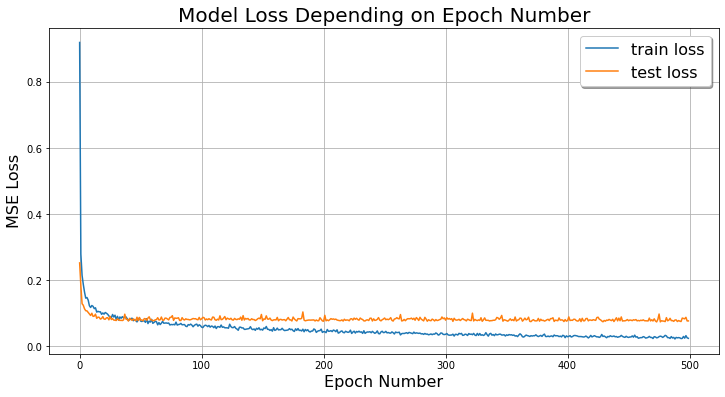


CPU times: user 58min 4s, sys: 2min 16s, total: 1h 20s
Wall time: 6min 15s


,RMSE,MAE,RSE,RAE,MAPE
mean,1.784161,1.158311,0.005764,0.004264,0.001924
std,0.101837,0.040665,0.000341,0.000172,0.000067


In [29]:
%%time

MODEL = "GP"
outputs = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in object_ids)
images_gp, true_peaks_gp, timestamps_gp = get_images(outputs)
X_test, y_test, y_test_pred_gp = light_curve_peak(images_gp, true_peaks_gp, timestamps_gp)
gen_report(y_test, y_test_pred_gp)

In [30]:
%%time

# direct
direct_peaks_gp = direct_peak_estimation(images_gp, timestamps_gp)
gen_report(true_peaks_gp, direct_peaks_gp)

CPU times: user 415 ms, sys: 3.93 ms, total: 419 ms
Wall time: 418 ms


,RMSE,MAE,RSE,RAE,MAPE
mean,3.292680,1.986877,0.010694,0.007317,0.003301
std,0.105315,0.050282,0.000361,0.000210,0.000084


In [31]:
images_gp.shape, true_peaks_gp.shape, timestamps_gp.shape

((2740, 6, 128), (2740,), (2740, 128))

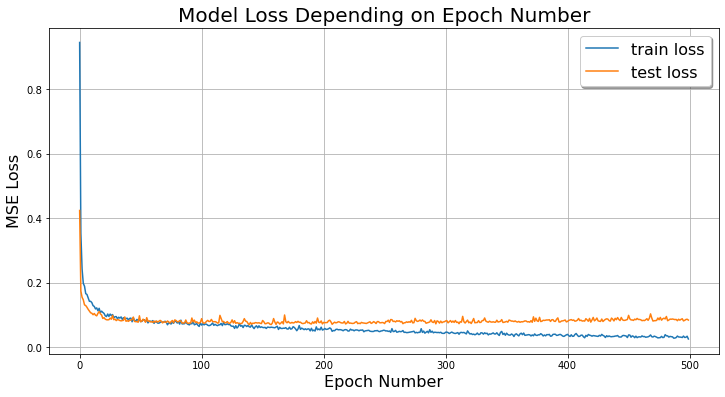


CPU times: user 57min 49s, sys: 2min 16s, total: 1h 6s
Wall time: 5min 51s


,RMSE,MAE,RSE,RAE,MAPE
mean,1.798676,1.220189,0.005817,0.004497,0.002027
std,0.072843,0.039936,0.000253,0.000172,0.000066


In [32]:
%%time

MODEL = "NN_sklearn"
params = {'passband2lam': passband2lam, 
          'hidden_layer_sizes': (20, 20),
          'solver': 'lbfgs',
          'activation': 'tanh',
          'learning_rate_init': 0.01,
          'max_iter': 90,
          'batch_size': 1}

outputs = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in object_ids)
images_sk, true_peaks_sk, timestamps_sk = get_images(outputs)
X_test, y_test, y_test_pred_sk = light_curve_peak(images_sk, true_peaks_sk, timestamps_sk)
gen_report(y_test, y_test_pred_sk)

In [33]:
%%time

# direct
direct_peaks_sk = direct_peak_estimation(images_sk, timestamps_sk)
gen_report(true_peaks_sk, direct_peaks_sk)

CPU times: user 413 ms, sys: 31 µs, total: 413 ms
Wall time: 412 ms


,RMSE,MAE,RSE,RAE,MAPE
mean,4.402662,2.901105,0.014301,0.010684,0.004820
std,0.107928,0.063503,0.000373,0.000265,0.000105


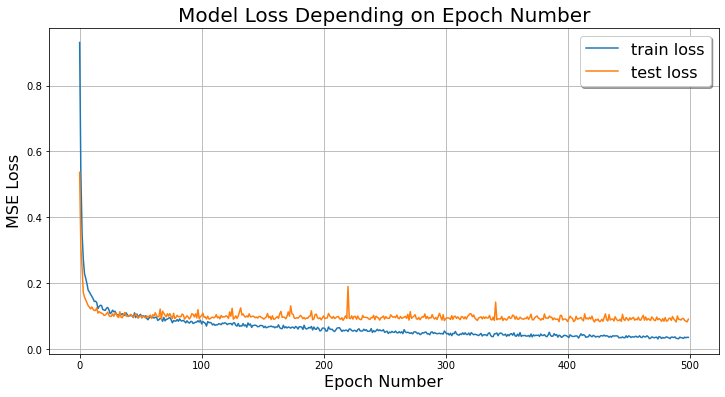


CPU times: user 58min 6s, sys: 2min 16s, total: 1h 22s
Wall time: 6min 1s


,RMSE,MAE,RSE,RAE,MAPE
mean,1.990168,1.388577,0.006431,0.005114,0.002307
std,0.065991,0.041881,0.000235,0.000185,0.000070


In [34]:
%%time

MODEL = "NN_pytorch"
params = {'passband2lam': passband2lam, 
          'n_hidden': 20, 
          'activation': 'tanh', 
          'n_epochs': 100, 
          'batch_size': 500, 
          'lr': 0.1, 
          'optimizer': 'Adam', 
          'device': 'auto'}

outputs = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in object_ids)
images_pt, true_peaks_pt, timestamps_pt = get_images(outputs)
X_test, y_test, y_test_pred_pt = light_curve_peak(images_pt, true_peaks_pt, timestamps_pt)
gen_report(y_test, y_test_pred_pt)

In [35]:
%%time

# direct
direct_peaks_pt = direct_peak_estimation(images_pt, timestamps_pt)
gen_report(true_peaks_pt, direct_peaks_pt)

CPU times: user 432 ms, sys: 0 ns, total: 432 ms
Wall time: 431 ms


,RMSE,MAE,RSE,RAE,MAPE
mean,5.202894,3.518739,0.016894,0.012949,0.005847
std,0.099470,0.074483,0.000357,0.000317,0.000124


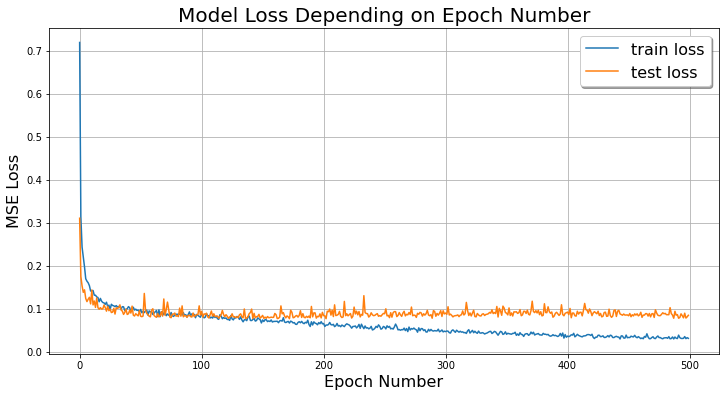


CPU times: user 59min 22s, sys: 2min 20s, total: 1h 1min 42s
Wall time: 11min 36s


,RMSE,MAE,RSE,RAE,MAPE
mean,1.991816,1.360561,0.006437,0.005011,0.002260
std,0.069966,0.042943,0.000240,0.000183,0.000071


In [36]:
%%time

MODEL = "BNN"
params = {'passband2lam': passband2lam, 
          'n_hidden': 20, 
          'prior_sigma': 0.1, 
          'n_epochs': 1000, 
          'lr': 0.01, 
          'kl_weight': 0.0001, 
          'optimizer': 'Adam', 
          'device': 'cpu'}

outputs = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in object_ids)
images_bn, true_peaks_bn, timestamps_bn = get_images(outputs)
X_test, y_test, y_test_pred_bn = light_curve_peak(images_bn, true_peaks_bn, timestamps_bn)
gen_report(y_test, y_test_pred_bn)

In [37]:
%%time

# direct
direct_peaks_bn = direct_peak_estimation(images_bn, timestamps_bn)
gen_report(true_peaks_bn, direct_peaks_bn)

CPU times: user 424 ms, sys: 3.99 ms, total: 428 ms
Wall time: 426 ms


,RMSE,MAE,RSE,RAE,MAPE
mean,6.089614,4.358139,0.019768,0.016034,0.007241
std,0.103697,0.081312,0.000383,0.000357,0.000135


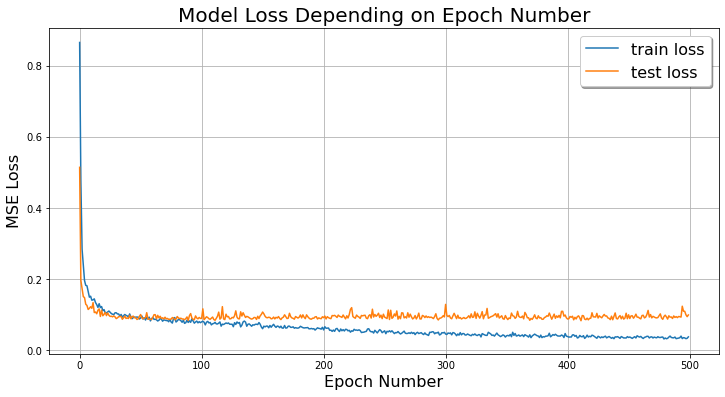


CPU times: user 1h 1min 13s, sys: 2min 25s, total: 1h 3min 39s
Wall time: 32min 29s


,RMSE,MAE,RSE,RAE,MAPE
mean,1.972063,1.346643,0.006376,0.004963,0.002238
std,0.076587,0.045033,0.000265,0.000191,0.000075


In [38]:
%%time

MODEL = "NF"
params = {'passband2lam': passband2lam, 
          'batch_size': 500, 
          'n_epochs': 1000, 
          'lr': 0.01, 
          'device': 'cpu'}

outputs = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in object_ids)
images_nf, true_peaks_nf, timestamps_nf = get_images(outputs)
X_test, y_test, y_test_pred_nf = light_curve_peak(images_nf, true_peaks_nf, timestamps_nf)
gen_report(y_test, y_test_pred_nf)

In [39]:
%%time

# direct
direct_peaks_nf = direct_peak_estimation(images_nf, timestamps_nf)
gen_report(true_peaks_nf, direct_peaks_nf)

CPU times: user 410 ms, sys: 20.2 ms, total: 430 ms
Wall time: 429 ms


,RMSE,MAE,RSE,RAE,MAPE
mean,5.574243,3.697559,0.018108,0.013616,0.006144
std,0.109044,0.078668,0.000395,0.000337,0.000131
